In [58]:
#imports
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
import string
import collections
import itertools
import re
import warnings
warnings.filterwarnings('ignore')

#matplotlib imports
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

#nltk imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

#sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,classification_report,auc
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.svm import SVC

In [60]:
# data
df = pd.read_csv("implicit_hate_v1_stg1_posts.tsv", delimiter='\t')
print(df.info())
print(df.head(n=20))
print(df['class'].describe())


df2 = pd.read_csv("implicit_hate_v1_stg2_posts.tsv", delimiter='\t')
print(df2.info())
print(df2.head(n=20))


df3 = pd.read_csv("implicit_hate_v1_stg3_posts.tsv", delimiter='\t')
#print(df3.info())
#print(df3.head(n=20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21480 entries, 0 to 21479
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   post    21480 non-null  object
 1   class   21480 non-null  object
dtypes: object(2)
memory usage: 335.8+ KB
None
                                                 post          class
0     " : jewish harvard professor noel ignatiev w...  implicit_hate
1    b.higher education is a part of european cult...       not_hate
2    has a problem with  " the whites " " and " " ...       not_hate
3    is yasir qadhi a hate preacher for calling ch...       not_hate
4    rt  " : how three million germans mass murder...       not_hate
5    rt  " we were murdered graffiti in synagogues...       not_hate
6    rt : tune in today's jmt for my interview w /...  implicit_hate
7    rt black supremacist arrested for threatening...       not_hate
8    rt crooked hillary you didn't lose because yo...  explicit_hate
9    rt est

In [3]:
#convert to lowercase, strip and remove punctuations and other unnecessary symbols
def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = re.sub(r'^rt[\s]+', '', text)
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [ ]:
corp = []
for i in range(0, len(df)):
    t = clean_text(df.post[i])
    corp.append(t)
    
df.post = corp
df.head()

17.742112676056337
16.272727272727273


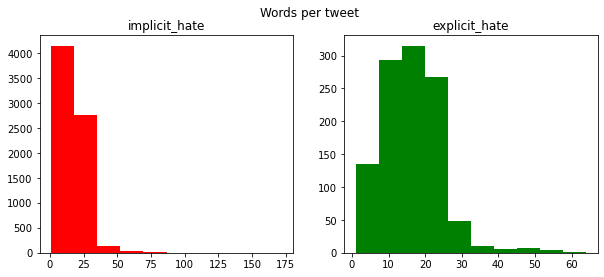

95.31028169014084
88.08539944903582


In [9]:
# WORD-COUNT
df_train = df
df_train['word_count'] = df_train['post'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['class']=='implicit_hate']['word_count'].mean()) #implicit_hate tweets
print(df_train[df_train['class']=='explicit_hate']['word_count'].mean()) #explicit_hate tweets

# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['class']=='implicit_hate']['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('implicit_hate')
train_words=df_train[df_train['class']=='explicit_hate']['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('explicit_hate')
fig.suptitle('Words per tweet')
plt.show()

# CHARACTER-COUNT
df_train['char_count'] = df_train['post'].apply(lambda x: len(str(x)))
print(df_train[df_train['class']=='implicit_hate']['char_count'].mean()) #implicit_hate tweets
print(df_train[df_train['class']=='explicit_hate']['char_count'].mean()) #explicit_hate tweets

In [11]:
count_vectorizer = CountVectorizer(ngram_range=(2,2))
a = count_vectorizer.fit_transform(df_train.post)
f = count_vectorizer.get_feature_names_out()
d = pd.DataFrame(a.toarray(), columns=f)
d.head(n=10)

,000 000,000 annually,000 get,000 haitians,000 illegal,000 illegals,000 is,000 lgbt,000 members,000 million,...,zones and,zones for,zones in,zoo with,zoology it,zuckerberg dream,zuckerberg is,zuckerberg promotes,zuckerburg gives,zuma talking
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
d['class'] = df['class']
d1 = d[d["class"]=='implicit_hate']
d2 = d[d["class"]=='explicit_hate']
d3 = d[d["class"]=='not_hate']

In [13]:
# compare most frequent n-grams in implicit_hate vs. explicit_hate

most_frequent_implicit_hate = d1.sum(numeric_only=True).sort_values(ascending=False)
most_frequent_explicit_hate = d2.sum(numeric_only=True).sort_values(ascending=False)

d_implicit = most_frequent_implicit_hate.to_frame().reset_index()
d_implicit.rename(columns= {0:'Sum', 'index':'Feature_implicit'},inplace=True)
d_implicit['percent'] = (d_implicit['Sum'] / d_implicit['Sum'].sum())*100
d_explicit = most_frequent_explicit_hate.to_frame().reset_index()
d_explicit.rename(columns= {0:'Sum', 'index':'Feature_explicit'},inplace=True)
d_explicit['percent'] = (d_explicit['Sum'] / d_explicit['Sum'].sum())*100
df_im_ex = pd.concat([d_implicit,d_explicit],axis=1)
df_im_ex.head(n=20)

,Feature_implicit,Sum,percent,Feature_explicit,Sum,percent
0,white people,170,0.538742,the white,22,0.426687
1,the white,110,0.348598,white people,20,0.387898
2,of the,81,0.256695,white race,18,0.349108
3,in the,72,0.228173,of the,17,0.329713
4,anti white,72,0.228173,to be,12,0.232739
5,to be,69,0.218666,do you,12,0.232739
6,white race,66,0.209159,black people,11,0.213344
7,they are,57,0.180637,for the,10,0.193949
8,you re,53,0.167961,they are,9,0.174554
9,you are,52,0.164792,no no,9,0.174554


In [15]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
df['clean_text'] = df['post'].apply(lambda x: finalpreprocess(x))

X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["class"],test_size=0.2,shuffle=True)

#Count-Vectorizer
cv_ngram2 = CountVectorizer(ngram_range=(2,2))
X_train_vectors_count = cv_ngram2.fit_transform(X_train)
X_test_vectors_count = cv_ngram2.transform(X_test)

In [16]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(2,2))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [17]:
#LogisticRegression Count-Vectorizer
lr_count=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_count.fit(X_train_vectors_count, y_train) 

#Predict y value for test dataset
y_predict = lr_count.predict(X_test_vectors_count)
y_prob = lr_count.predict_proba(X_test_vectors_count)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, y_prob,pos_label='implicit_hate')
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

               precision    recall  f1-score   support

explicit_hate       0.54      0.10      0.16       198
implicit_hate       0.89      0.99      0.94      1440

     accuracy                           0.88      1638
    macro avg       0.72      0.54      0.55      1638
 weighted avg       0.85      0.88      0.84      1638

Confusion Matrix: [[  19  179]
 [  16 1424]]
AUC: 0.6350291105499438


In [18]:
#Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, y_prob,pos_label='implicit_hate')
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

               precision    recall  f1-score   support

explicit_hate       0.54      0.11      0.18       198
implicit_hate       0.89      0.99      0.94      1440

     accuracy                           0.88      1638
    macro avg       0.71      0.55      0.56      1638
 weighted avg       0.85      0.88      0.84      1638

Confusion Matrix: [[  21  177]
 [  18 1422]]
AUC: 0.6357200476992144


In [19]:
#SVM Count-Vectorizer
svm = SVC(kernel='rbf',probability=True)
svm.fit(X_train_vectors_count, y_train) 
y_pred = svm.predict(X_test_vectors_count)
y_prob = svm.predict_proba(X_test_vectors_count)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob,pos_label='implicit_hate')
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

               precision    recall  f1-score   support

explicit_hate       0.54      0.11      0.18       198
implicit_hate       0.89      0.99      0.94      1440

     accuracy                           0.88      1638
    macro avg       0.71      0.55      0.56      1638
 weighted avg       0.85      0.88      0.84      1638

Confusion Matrix: [[  21  177]
 [  18 1422]]
AUC: 0.6225536616161617


In [20]:
# not hate vs. implicite hate
# implicite vs. explicite
# n-gram, tf-idf, Glo Ve?
# link datasets
# k-means 7 or 8 -> 
#Black Separatist (27.1%), White Nationalist (16.4%), NeoNazi (6.2%), Anti-Muslim (8.9%), Racist Skinhead
#(5.1%), Ku Klux Klan (5.0%), Anti-LGBT (7.4%),
#and Anti-Immigrant (2.12%)

In [21]:
# data implicit_hate vs. not_hate
df = pd.read_csv("implicit_hate_v1_stg1_posts.tsv", delimiter='\t')
df = df[df['class'] != 'explicit_hate']
print(df.info())
print(df.head(n=20))
print(df['class'].describe())
print(df["class"].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20391 entries, 0 to 21479
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   post    20391 non-null  object
 1   class   20391 non-null  object
dtypes: object(2)
memory usage: 477.9+ KB
None
                                                 post          class
0     " : jewish harvard professor noel ignatiev w...  implicit_hate
1    b.higher education is a part of european cult...       not_hate
2    has a problem with  " the whites " " and " " ...       not_hate
3    is yasir qadhi a hate preacher for calling ch...       not_hate
4    rt  " : how three million germans mass murder...       not_hate
5    rt  " we were murdered graffiti in synagogues...       not_hate
6    rt : tune in today's jmt for my interview w /...  implicit_hate
7    rt black supremacist arrested for threatening...       not_hate
10   we capitalize neither  " white " " nor " " bl...       not_hate
11   when y

In [62]:
df['clean_text'] = df['post'].apply(lambda x: finalpreprocess(x))
df.head()

,post,class,clean_text
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate,jewish harvard professor noel ignatiev want ab...
1,b.higher education is a part of european cult...,not_hate,b high education part european culture import ...
2,"has a problem with "" the whites "" "" and "" "" ...",not_hate,problem white christian go ahead free say
3,is yasir qadhi a hate preacher for calling ch...,not_hate,yasir qadhi hate preacher call christian filth...
4,"rt "" : how three million germans mass murder...",not_hate,three million german mass murder destruction r...


In [24]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"],df["class"],test_size=0.2,shuffle=True)

#Count-Vectorizer
cv_ngram2 = CountVectorizer(ngram_range=(2,4),min_df=10)
X_train_vectors_count = cv_ngram2.fit_transform(X_train)
X_test_vectors_count = cv_ngram2.transform(X_test)

In [25]:
df2['clean_text'] = df2['post'].apply(lambda x: finalpreprocess(x))
df2.head()

,post,implicit_class,extra_implicit_class,clean_text
0,""" : jewish harvard professor noel ignatiev w...",white_grievance,NaN,jewish harvard professor noel ignatiev want ab...
1,rt : tune in today's jmt for my interview w /...,irony,NaN,tune today jmt interview w robert spencer comp...
2,: : hate posters ? you want hate buddy ? read ...,white_grievance,NaN,hate poster want hate buddy read koran goo
3,: hunt for white women : black racist serial k...,stereotypical,NaN,hunt white woman black racist serial killer co...
4,: looks like he was a fan of the islamic jew-h...,stereotypical,NaN,look like fan islamic jew hate reza aslan pedd...


In [26]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(2,4))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [27]:
#SVM Count-Vectorizer
svm = SVC(kernel='rbf',probability=True)
svm.fit(X_train_vectors_count, y_train) 
y_pred = svm.predict(X_test_vectors_count)
y_prob = svm.predict_proba(X_test_vectors_count)[:,1]

In [28]:
print(classification_report(y_test,y_pred))
print('Confusion Matrix:',confusion_matrix(y_test, y_pred))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob,pos_label='implicit_hate')
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

               precision    recall  f1-score   support

implicit_hate       0.61      0.24      0.34      1402
     not_hate       0.70      0.92      0.79      2677

     accuracy                           0.69      4079
    macro avg       0.66      0.58      0.57      4079
 weighted avg       0.67      0.69      0.64      4079

Confusion Matrix: [[ 335 1067]
 [ 211 2466]]
AUC: 0.40731701923235764


In [29]:
#SVM if-idf
svm = SVC(kernel='rbf',probability=True)
svm.fit(X_train_vectors_tfidf, y_train) 
y_pred = svm.predict(X_test_vectors_tfidf)
y_prob = svm.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_pred))
print('Confusion Matrix:',confusion_matrix(y_test, y_pred))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob,pos_label='implicit_hate')
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

               precision    recall  f1-score   support

implicit_hate       0.69      0.13      0.22      1402
     not_hate       0.68      0.97      0.80      2677

     accuracy                           0.68      4079
    macro avg       0.69      0.55      0.51      4079
 weighted avg       0.69      0.68      0.60      4079

Confusion Matrix: [[ 182 1220]
 [  80 2597]]
AUC: 0.318128699222041


In [30]:
df_n = (pd.merge(df,df2,on=['clean_text','clean_text'],how='outer'))
df_n.drop('post_x',axis=1,inplace=True)
df_n.drop('post_y',axis=1,inplace=True)
df_n

,class,clean_text,implicit_class,extra_implicit_class
0,implicit_hate,jewish harvard professor noel ignatiev want ab...,white_grievance,NaN
1,not_hate,b high education part european culture import ...,NaN,NaN
2,not_hate,problem white christian go ahead free say,NaN,NaN
3,not_hate,yasir qadhi hate preacher call christian filth...,NaN,NaN
4,not_hate,three million german mass murder destruction r...,NaN,NaN
...,...,...,...,...
20481,NaN,cucks would rather rap knife call racist deser...,incitement,NaN
20482,NaN,muslim murder jewish girlfriend say im go kill...,stereotypical,NaN
20483,NaN,first slave owner america black man read via w...,white_grievance,NaN
20484,NaN,david lane open letter dead white race via rt,white_grievance,NaN


In [32]:
l = df_n.extra_implicit_class
a = df_n.implicit_class
list(set(l))

[nan,
 'stereotypical',
 'threatening',
 'irony',
 'white_grievance',
 'inferiority',
 'incitement']

In [64]:
df = df[df['class'] != 'not_hate']
print(df.head)
corpus = df['clean_text'].tolist()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(),columns=vectorizer.get_feature_names())

final_df = tf_idf
print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5,0)

<bound method NDFrame.head of                                                     post          class  \
0        " : jewish harvard professor noel ignatiev w...  implicit_hate   
6       rt : tune in today's jmt for my interview w /...  implicit_hate   
8       rt crooked hillary you didn't lose because yo...  explicit_hate   
9       rt estonian pm :  " i don't want blacks in es...  explicit_hate   
18     : : hate posters ? you want hate buddy ? read ...  implicit_hate   
...                                                  ...            ...   
21475  Seeing prostitutes is morally wrong, but being...  implicit_hate   
21476  I wonder how many females I raped today I spen...  implicit_hate   
21477  Having a criminal record is more attractive to...  implicit_hate   
21478  Another advantage of being a female: getting b...  implicit_hate   
21479  If men are so privileged and women have it so ...  implicit_hate   

                                              clean_text  
0      jew

,0,1,2,3,4,5,6,7,8,9,...,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188
ignatiev,0.396689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
noel,0.396689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wr,0.374496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abolish,0.368934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
harvard,0.359459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [66]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [68]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
#silhouette(kmeans_results, final_df, plot=True)

In [69]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

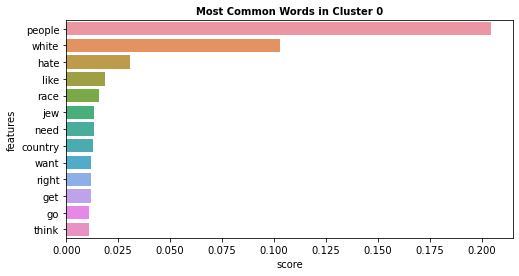

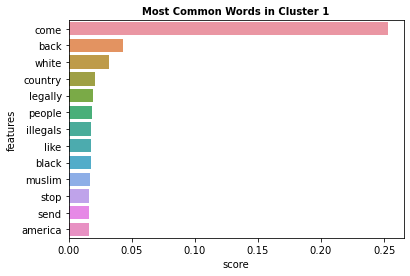

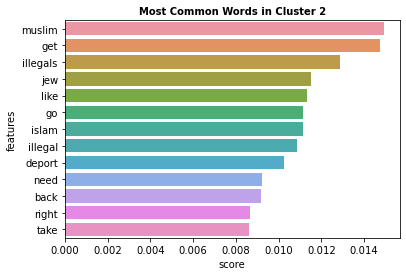

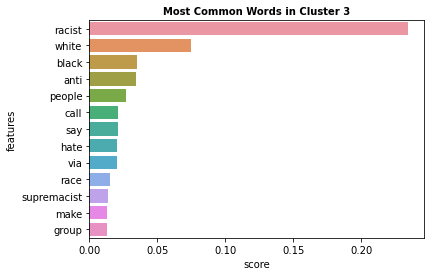

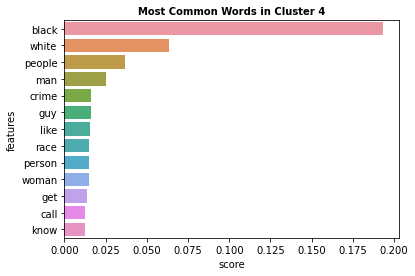

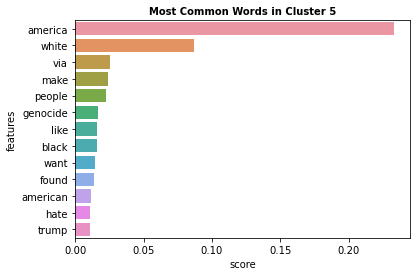

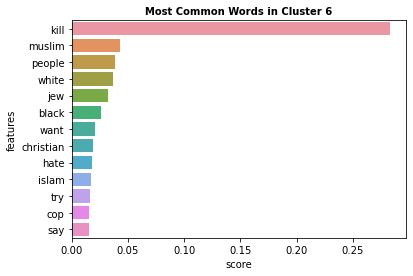

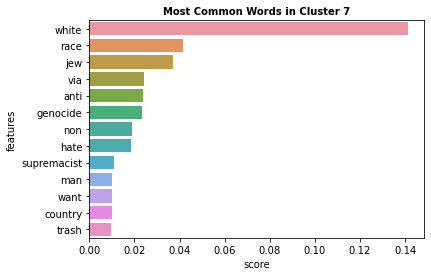

In [70]:
best_result = 8
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [71]:
# Assigning the cluster labels to each 
labels = kmeans.labels_ 
df['label'] = labels
df.head()

,post,class,clean_text,label
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate,jewish harvard professor noel ignatiev want ab...,7
6,rt : tune in today's jmt for my interview w /...,implicit_hate,tune today jmt interview w robert spencer comp...,2
8,rt crooked hillary you didn't lose because yo...,explicit_hate,crooked hillary lose portray agent change loss...,2
9,"rt estonian pm : "" i don't want blacks in es...",explicit_hate,estonian pm want black estonia white country v...,4
18,: : hate posters ? you want hate buddy ? read ...,implicit_hate,hate poster want hate buddy read koran goo,2


In [92]:
#label 0 
#label 1 Racist Skinhead
#label 2 White Nationalist
#label 3 Ku Klux Klan
#label 4
#label 5 Anti-Muslim
#label 6 Anti-Immigrant
#label 7 Neo Nazi
s = df.label
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
pd.DataFrame({'counts': counts,'per100':percent100})

,counts,per100
2,3458,42.2%
7,1974,24.1%
0,684,8.4%
4,674,8.2%
3,470,5.7%
5,373,4.6%
6,362,4.4%
1,194,2.4%


In [74]:
df_t = (df[(df['label']==2)])
df_t = df_t['post']
df_t.to_csv('t2.csv',sep=' ', index=False, header=False)

In [91]:
for k in range(7):
    df_t = (df[(df['label']==k)])
    df_t = df_t['post']
    df_t.to_csv(f't{k}.csv',sep=' ', index=False, header=False)